# Exploring and Clustering Toronto Neighborhoods

<font size=3>This assignment explores, segments, and clusters Toronto neighborhoods. 
Toronto neighborhood data was scraped, wrangled, and cleaned from an older Wikipedia page to match the requirements of this assignment. 
Once that was done, the data was put into a dataframe similar to the one used in the New York City Homework and then the data was analyzed and clustered in the same manner as the New York City example.</font>


<font size = 3>Note: Please use Table of Contents for jumping to pertinent section of homework assignment)<a id="TOC"></a></font>

# Table of Contents 
<div class="alert alert-block alert-info" style="margin-top: 20px">
<font size = 3>

1. <a href="#section1">Retrieve Data and Create Pandas Data Frame</a>

2. <a href="#section2">Retrieving and Appending Latitude and Longitude Data</a>

3. <a href="#section3">Explore and Cluster Each Neighborhood</a>

</font>
</div>


   

### Import and Install Packages Needed

In [1]:
!pip install pandas==1.0.3
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib.pyplot as plt # plotting library
# backend for rendering plots within the browser
%matplotlib inline 

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library


from sklearn.datasets.samples_generator import make_blobs

!pip install requests beautifulsoup4
print('Libraries imported.')


     |████████████████████████████████| 10.0MB 5.8MB/s eta 0:00:01
ERROR: ibm-watson-machine-learning 1.0.8 has requirement pandas<=0.25.3, but you'll have pandas 1.0.3 which is incompatible.
ERROR: autoai-libs 1.10.5 has requirement numpy>=1.16.4, but you'll have numpy 1.15.4 which is incompatible.
  Found existing installation: pandas 0.24.1
    Uninstalling pandas-0.24.1:
      Successfully uninstalled pandas-0.24.1
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 

In [2]:
from bs4 import BeautifulSoup
import requests
!pip show beautifulsoup4

!pip install lxml
import requests
import lxml.html as lh
print('imports finished')


Name: beautifulsoup4
Version: 4.7.1
Summary: Screen-scraping library
Home-page: http://www.crummy.com/software/BeautifulSoup/bs4/
Author: Leonard Richardson
Author-email: leonardr@segfault.org
License: MIT
Location: /opt/conda/envs/Python36/lib/python3.6/site-packages
Requires: soupsieve
Required-by: 
imports finished


<a id='section1'></a>
## 1. Retrieve Data and Create Pandas Data Frame
<a href="#TOC">Back to TOC</a>

### Scraping of the Wikipedia page: 


In [3]:
# url="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
##need to use link to old data

url="https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&direction=prev&oldid=926287641"
#Create a handle, page, to handle the contents of the website
page = requests.get(url)
#Store the contents of the website under doc
doc = lh.fromstring(page.content)
#Parse data that are stored between <tr>..</tr> of HTML
tr_elements = doc.xpath('//tr')
#Check the length of the first 12 rows
[len(T) for T in tr_elements[:12]]

tr_elements = doc.xpath('//tr')
#Create empty list
col=[]
i=0
#For each row, store each first element (header) and an empty list
for t in tr_elements[0]:
    i+=1
    name=t.text_content()
    name = name.replace('\n', '').strip()
    print ('%d:"%s"'%(i,name))
    col.append((name,[]))


1:"Postcode"
2:"Borough"
3:"Neighbourhood"


In [4]:
#Since out first row is the header, data is stored on the second row onwards

for j in range(1,len(tr_elements)):
    #T is our j'th row
    T=tr_elements[j]
    
    #If row is not of size 3 the //tr data is not from our table 
    if len(T)!=3:
        break
    
    #i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        data=t.text_content()
        data = data.replace('\n','')
#       data = data.replace('\n','X').strip()

        #Check if row is empty
        if i>0:
        #Convert any numerical value to integers
            try:
                data=int(data)
            except:
                pass
        #Append the data to the empty list of the i'th column
        col[i][1].append(data)
        #Increment i for the next column
        i+=1
[len(C) for (title,C) in col]



[288, 288, 288]

### Create Pandas Dataframe

In [5]:
# Code for creating dataframe--# The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
# Used data headers as they appear in Wiki

Dict={title:column for (title,column) in col}
df=pd.DataFrame(Dict)

print('data file size',df.shape)

# Combining neighborhoods with the same Postcode
clean_df=df.groupby(['Postcode','Borough']).agg({'Neighbourhood':','.join}).reset_index()

print("Before",df.tail())



data file size (288, 3)
Before     Postcode       Borough          Neighbourhood
283      M8Z     Etobicoke              Mimico NW
284      M8Z     Etobicoke     The Queensway West
285      M8Z     Etobicoke  Royal York South West
286      M8Z     Etobicoke         South of Bloor
287      M9Z  Not assigned           Not assigned


In [6]:
# Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.

print('# in dirty data', clean_df.shape)

bor_na=len(clean_df[ (clean_df['Borough'] == 'Not assigned') ].index)
nbh_na=len(clean_df[ (clean_df['Neighbourhood'] == 'Not assigned') ].index) 
bth_na=len(clean_df[ (clean_df['Borough'] == 'Not assigned') & (clean_df['Neighbourhood'] == 'Not assigned') ].index)

print('NA for Boroughs--Before',bor_na)
print('NA for Neighborhood--Before',nbh_na)
print('NA for Both--Before', bth_na)

index_names = clean_df[ (clean_df['Borough'] == 'Not assigned') & (clean_df['Neighbourhood'] == 'Not assigned') ].index 

clean_df.drop(index_names, inplace = True)

# clean_df = clean_df[clean_df[]District = 'Not Assigned') & (clean_df.Neighbourhood = 'Not Assigned')], inplace=True)
index_NNA = clean_df[ (clean_df['Borough'] != 'Not assigned') & (clean_df['Neighbourhood'] == 'Not assigned') ].index 


print('Neighborhood with no data',index_NNA)


bor_naa=len(clean_df[ (clean_df['Borough'] == 'Not assigned') ].index)
nbh_naa=len(clean_df[ (clean_df['Neighbourhood'] == 'Not assigned') ].index) 
bth_naa=len(clean_df[ (clean_df['Borough'] == 'Not assigned') & (clean_df['Neighbourhood'] == 'Not assigned') ].index)


print('NA for Boroughs--After',bor_naa)
print('NA for Neighborhood--After',nbh_naa)
print('NA for Both--After', bth_naa)

clean_df.rename(columns={'Postcode': 'PostalCode', 'Neighbourhood': 'Neighborhood'},inplace=True) #code for current wiki page
#clean_df.rename(columns={Neighbourhood': 'Neighborhood'},inplace=True)

print('# in clean data', clean_df.shape)
#clean_df.tail(10)

# in dirty data (180, 3)
NA for Boroughs--Before 77
NA for Neighborhood--Before 78
NA for Both--Before 77
Neighborhood with no data Int64Index([120], dtype='int64')
NA for Boroughs--After 0
NA for Neighborhood--After 1
NA for Both--After 0
# in clean data (103, 3)


In [7]:
### Restricting data by postal codes kept
#keep=pd.DataFrame({'Postcode':['M5G','M2H', 'M4B', 'M1J', 'M4G', 'M4M', 'M1R', 'M9V', 'M9L', 'M5V', 'M1B', 'M5A'], 'keep':['1','1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1']})

keep=pd.DataFrame({'PostalCode':['M5G','M2H', 'M4B', 'M1J', 'M4G', 'M4M', 'M1R', 'M9V', 'M9L', 'M5V', 'M1B', 'M5A']})

keep_df=keep.join(clean_df.set_index('PostalCode'), on='PostalCode')

#keep_df

In [8]:
print('Number of rows in final dataframe =', keep_df.shape[0])

Number of rows in final dataframe = 12


<a id='section2'></a>
## 2. Retrieving and Appending Latitude and Longitude Data
<a href="#TOC">Back to TOC</a>

#### Loop for Retrieving Geocoder Data for Latitude and Longitude

In [9]:
!pip install geocoder
import geocoder # import geocoder


     |████████████████████████████████| 102kB 9.9MB/s eta 0:00:01


### Not using due to issues retrieving data

In [10]:
#postal_code=clean_df['PostalCode']
#print('Postal Code',postal_code)

# initialize your variable to None
#lat_lng_coords = None

# loop until you get the coordinates
#while(lat_lng_coords is None):
#    g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
#    lat_lng_coords = g.latlng

#g = geocoder.google('Toronto, Ontario')
#g.latlng

#latitude = lat_lng_coords[0]
#longitude = lat_lng_coords[1]

#lat_lng_coords.head()
#print('Lat Long', g.latlng)


### Using Backup Due to Geocoder Reliability Issues

In [11]:
# Retrieve data from: http://cocl.us/Geospatial_data

!wget -q -O 'Geospatial_Coordinates.csv' http://cocl.us/Geospatial_data
print('Data downloaded!')

geodat_df = pd.read_csv('Geospatial_Coordinates.csv')
geodat_df.tail()

Data downloaded!


,Postal Code,Latitude,Longitude
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437
102,M9W,43.706748,-79.594054


In [12]:
#Append Lat/Long Data using join

tor_df=keep_df.join(geodat_df.set_index('Postal Code'), on='PostalCode')
tor_df

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
1,M2H,North York,Hillcrest Village,43.803762,-79.363452
2,M4B,East York,"Woodbine Gardens,Parkview Hill",43.706397,-79.309937
3,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
4,M4G,East York,Leaside,43.709060,-79.363452
5,M4M,East Toronto,Studio District,43.659526,-79.340923
6,M1R,Scarborough,"Maryvale,Wexford",43.750072,-79.295849
7,M9V,Etobicoke,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",43.739416,-79.588437
8,M9L,North York,Humber Summit,43.756303,-79.565963
9,M5V,Downtown Toronto,"CN Tower,Bathurst Quay,Island airport,Harbourf...",43.628947,-79.394420


<a id='section3'></a>
## 3. Explore and Cluster Each Neighborhood 
<a href="#TOC">Back to TOC</a>


In [13]:
#Drop Postal Code Info

clust_df=clean_df.join(geodat_df.set_index('Postal Code'), on='PostalCode')

Tor_data = clust_df.drop(["PostalCode"], axis = 1) 
Tor_data

,Borough,Neighborhood,Latitude,Longitude
1,Scarborough,"Rouge,Malvern",43.806686,-79.194353
2,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
3,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
4,Scarborough,Woburn,43.770992,-79.216917
5,Scarborough,Cedarbrae,43.773136,-79.239476
6,Scarborough,Scarborough Village,43.744734,-79.239476
7,Scarborough,"East Birchmount Park,Ionview,Kennedy Park",43.727929,-79.262029
8,Scarborough,"Clairlea,Golden Mile,Oakridge",43.711112,-79.284577
9,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West",43.716316,-79.239476
10,Scarborough,"Birch Cliff,Cliffside West",43.692657,-79.264848


In [16]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="tor_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto, ON are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto, ON are 43.6534817, -79.3839347.


In [17]:
# create map of Toronto using latitude and longitude values

map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(Tor_data['Latitude'], Tor_data['Longitude'], Tor_data['Borough'], Tor_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### Define Foursquare Credentials and Version

In [26]:
# The code was removed by Watson Studio for sharing.

In [22]:
LIMIT=100
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [23]:

Tor_venues = getNearbyVenues(names=Tor_data['Neighborhood'],
                                   latitudes=Tor_data['Latitude'],
                                   longitudes=Tor_data['Longitude']
                                  )


Rouge,Malvern
Highland Creek,Rouge Hill,Port Union
Guildwood,Morningside,West Hill
Woburn
Cedarbrae
Scarborough Village
East Birchmount Park,Ionview,Kennedy Park
Clairlea,Golden Mile,Oakridge
Cliffcrest,Cliffside,Scarborough Village West
Birch Cliff,Cliffside West
Dorset Park,Scarborough Town Centre,Wexford Heights
Maryvale,Wexford
Agincourt
Clarks Corners,Sullivan,Tam O'Shanter
Agincourt North,L'Amoreaux East,Milliken,Steeles East
L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview,Henry Farm,Oriole
Bayview Village
Silver Hills,York Mills
Newtonbrook,Willowdale
Willowdale South
York Mills West
Willowdale West
Parkwoods
Don Mills North
Flemingdon Park,Don Mills South
Bathurst Manor,Downsview North,Wilson Heights
Northwood Park,York University
CFB Toronto,Downsview East
Downsview West
Downsview Central
Downsview Northwest
Victoria Village
Woodbine Gardens,Parkview Hill
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West,Riverdale
The Beaches West,Indi

In [24]:
print(Tor_venues.shape)
Tor_venues.head()

(2160, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge,Malvern",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,Chris Effects Painting,43.784343,-79.163742,Construction & Landscaping
2,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
3,"Guildwood,Morningside,West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
4,"Guildwood,Morningside,West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


In [25]:
Tor_venues.groupby('Neighborhood').count()
print('There are {} uniques categories.'.format(len(Tor_venues['Venue Category'].unique())))

There are 268 uniques categories.


## Analyze Neighborhood

In [27]:
# one hot encoding
Tor_onehot = pd.get_dummies(Tor_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Tor_onehot['Neighborhood'] = Tor_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Tor_onehot.columns[-1]] + list(Tor_onehot.columns[:-1])
Tor_onehot = Tor_onehot[fixed_columns]

Tor_onehot.head()
print("Toronto Venues", Tor_onehot.shape)


Toronto Venues (2160, 268)


In [28]:
Tor_grouped = Tor_onehot.groupby('Neighborhood').mean().reset_index()

print("New Toronto file size", Tor_grouped.shape)
Tor_grouped.tail(10)

New Toronto file size (100, 268)


,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hospital,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Movie Theater,Moving Target,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Plane,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Post Office,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,River,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
90,Thorncliffe Park,0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.050000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

### Top 5 Venues

In [29]:
num_top_venues = 5

for hood in Tor_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Tor_grouped[Tor_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')
    
### Put info in a dataframe
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]


----Adelaide,King,Richmond----
            venue  freq
0     Coffee Shop  0.08
1            Café  0.05
2      Restaurant  0.04
3  Clothing Store  0.04
4             Gym  0.04


----Agincourt----
                       venue  freq
0                     Lounge  0.25
1               Skating Rink  0.25
2  Latin American Restaurant  0.25
3             Breakfast Spot  0.25
4                Men's Store  0.00


----Agincourt North,L'Amoreaux East,Milliken,Steeles East----
                      venue  freq
0                      Park  0.33
1                Playground  0.33
2          Sculpture Garden  0.33
3  Mediterranean Restaurant  0.00
4        Miscellaneous Shop  0.00


----Albion Gardens,Beaumond Heights,Humbergate,Jamestown,Mount Olive,Silverstone,South Steeles,Thistletown----
                  venue  freq
0         Grocery Store  0.25
1  Fast Food Restaurant  0.12
2           Pizza Place  0.12
3        Sandwich Place  0.12
4            Beer Store  0.12


----Alderwood,Long Branch----
  

### Top 10 Venues

In [30]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Tor_grouped['Neighborhood']

for ind in np.arange(Tor_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Tor_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()



,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide,King,Richmond",Coffee Shop,Café,Gym,Restaurant,Clothing Store,Bar,Hotel,Thai Restaurant,Office,Pizza Place
1,Agincourt,Latin American Restaurant,Lounge,Breakfast Spot,Skating Rink,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Escape Room,Donut Shop
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",Park,Sculpture Garden,Playground,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant,Eastern European Restaurant,Dance Studio,Dog Run
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",Grocery Store,Pharmacy,Fried Chicken Joint,Sandwich Place,Pizza Place,Fast Food Restaurant,Beer Store,Donut Shop,Doner Restaurant,Deli / Bodega
4,"Alderwood,Long Branch",Pizza Place,Gym,Coffee Shop,Pub,Skating Rink,Athletics & Sports,Sandwich Place,Diner,Department Store,Dessert Shop


## For Clustering Toronto Neighborhoods

In [34]:
Tor_grouped_clust = Tor_grouped.drop('Neighborhood', 1)
distortions = []
K = range(1,11)
for k in K:
    kmm = KMeans(n_clusters=k)
    kmm.fit(Tor_grouped_clust)
    distortions.append(kmm.inertia_)


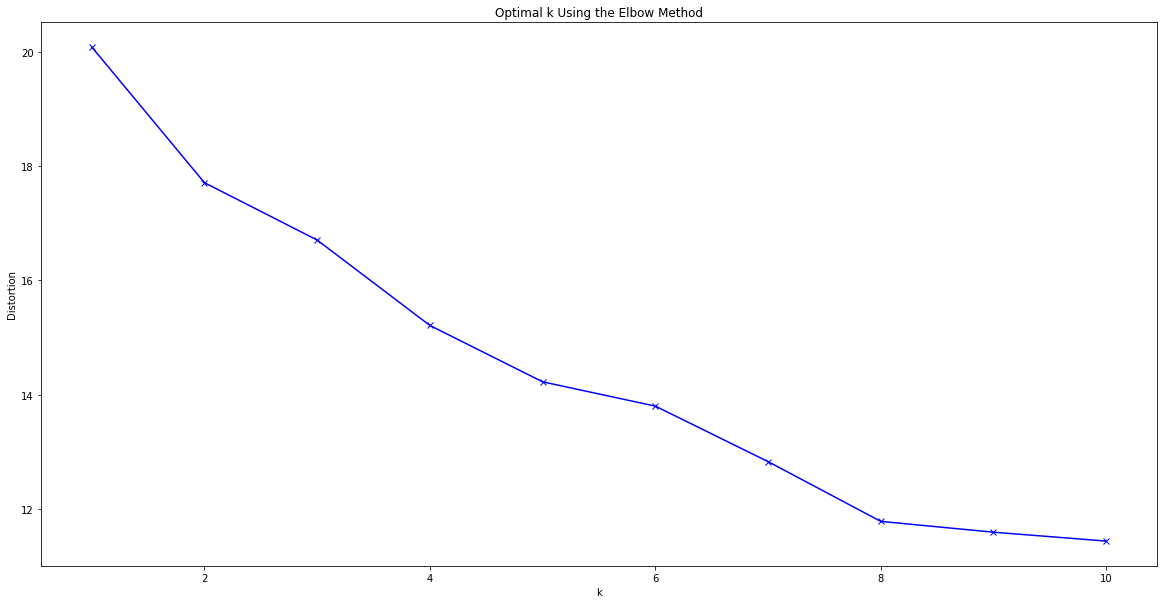

In [35]:
plt.figure(figsize=(20,10))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Optimal k Using the Elbow Method')
plt.show()


In [36]:
# according to plot k=3 point where returns drastically start to level off

# set number of clusters
kclusters = 3

Tor_grouped_clust = Tor_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Tor_grouped_clust)

# check sample of cluster labels generated for each row in the dataframe
kmeans.labels_[1:104]

array([0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       2, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2], dtype=int32)

In [37]:
Tor_merged=Tor_data

In [38]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Tor_merged = Tor_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

clus_drop = Tor_merged[ (Tor_merged['1st Most Common Venue'] == 'NaN') ].index 

Tor_merged.dropna(inplace=True)

Tor_merged['Cluster Labels']=Tor_merged['Cluster Labels'].astype(int)

print(Tor_merged.dtypes) 

Tor_merged.head() # check the last columns & for NaN in Cluster Labels



Borough                    object
Neighborhood               object
Latitude                  float64
Longitude                 float64
Cluster Labels              int64
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
dtype: object


,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Scarborough,"Rouge,Malvern",43.806686,-79.194353,0,Fast Food Restaurant,Women's Store,Deli / Bodega,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run
2,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,0,Construction & Landscaping,Bar,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Women's Store,Department Store
3,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,0,Electronics Store,Moving Target,Breakfast Spot,Medical Center,Intersection,Bank,Restaurant,Rental Car Location,Mexican Restaurant,Convenience Store
4,Scarborough,Woburn,43.770992,-79.216917,0,Coffee Shop,Convenience Store,Korean Restaurant,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
5,Scarborough,Cedarbrae,43.773136,-79.239476,0,Gas Station,Thai Restaurant,Fried Chicken Joint,Bank,Athletics & Sports,Caribbean Restaurant,Bakery,Hakka Restaurant,Donut Shop,Doner Restaurant


In [39]:
# create map
#kclusters = 3
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Tor_merged['Latitude'], Tor_merged['Longitude'], Tor_merged['Neighborhood'], Tor_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine Clusters

#### Cluster 1: Restaurant Lovers
Primarily Restaurants/Cafes in Top 10 Venues<br>
Nearly all neighborhoods are in this cluster. In the "real world" would look for other attributes to differentiate clusters

In [40]:
Tor_merged.loc[Tor_merged['Cluster Labels'] == 0, Tor_merged.columns[[1] + list(range(5, Tor_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Rouge,Malvern",Fast Food Restaurant,Women's Store,Deli / Bodega,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run
2,"Highland Creek,Rouge Hill,Port Union",Construction & Landscaping,Bar,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Women's Store,Department Store
3,"Guildwood,Morningside,West Hill",Electronics Store,Moving Target,Breakfast Spot,Medical Center,Intersection,Bank,Restaurant,Rental Car Location,Mexican Restaurant,Convenience Store
4,Woburn,Coffee Shop,Convenience Store,Korean Restaurant,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
5,Cedarbrae,Gas Station,Thai Restaurant,Fried Chicken Joint,Bank,Athletics & Sports,Caribbean Restaurant,Bakery,Hakka Restaurant,Donut Shop,Doner Restaurant
6,Scarborough Village,Smoke Shop,Playground,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dance Studio,Dog Run
7,"East Birchmount Park,Ionview,Kennedy Park",Bus Station,Chinese Restaurant,Coffee Shop,Discount Store,Hobby Shop,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Distribution Center
8,"Clairlea,Golden Mile,Oakridge",Bus Line,Bakery,Park,Intersection,Ice Cream Shop,Soccer Field,Drugstore,Donut Shop,Doner Restaurant,Dog Run
9,"Cliffcrest,Cliffside,Scarborough Village West",American Restaurant,Motel,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Women's Store
10,"Birch Cliff,Cliffside West",Skating Rink,College Stadium,Café,General Entertainment,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center


#### Cluster 2: Let'sPlay Ball! 
Baseball Field is most common venue with max of 4 restaurants in Top 10 Venues

In [41]:
Tor_merged.loc[Tor_merged['Cluster Labels'] == 1, Tor_merged.columns[[1] + list(range(5, Tor_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
158,"Humber Bay,King's Mill Park,Kingsway Park Sout...",Baseball Field,Women's Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Event Space
169,"Emery,Humberlea",Baseball Field,Women's Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Event Space


#### Cluster 3: Nature Lovers

Park is most common venue with max of 4 restaurants in Top 10 Venues

In [42]:
Tor_merged.loc[Tor_merged['Cluster Labels'] == 2, Tor_merged.columns[[1] + list(range(5, Tor_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,"Agincourt North,L'Amoreaux East,Milliken,Steel...",Park,Sculpture Garden,Playground,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant,Eastern European Restaurant,Dance Studio,Dog Run
29,"Newtonbrook,Willowdale",Park,Dance Studio,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Distribution Center
31,York Mills West,Park,Convenience Store,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Dance Studio
40,Parkwoods,Park,Construction & Landscaping,Food & Drink Shop,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Deli / Bodega
47,"CFB Toronto,Downsview East",Park,Airport,Playground,Dumpling Restaurant,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Curling Ice
66,East Toronto,Park,Convenience Store,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Dance Studio
74,"Moore Park,Summerhill East",Park,Tennis Court,Trail,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run
76,Rosedale,Park,Trail,Playground,Dumpling Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run,Eastern European Restaurant,Curling Ice
91,"Forest Hill North,Forest Hill West",Park,Sushi Restaurant,Jewelry Store,Trail,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
103,Caledonia-Fairbanks,Park,Pool,Women's Store,Afghan Restaurant,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Drugstore,Donut Shop


### Reminder: Don't forget to submit a link to your Notebook on Github Three Separate Times